In [1]:
# Check keras and tensorflow versions
import keras
import tensorflow as tf

print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)

Keras version:  2.4.3
Tensorflow version:  2.4.0


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                                                 # for visualisation
import seaborn as sns
import re                                                                       # for regular expression
import string                                                                   # for handling string
import math                                                                     # for math

                                         # for EDA

# Packages for data preparation
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import keras
from keras import models
from keras import layers
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import tensorflow as tf

from sklearn.metrics import confusion_matrix                                    # for the modelling and plotting of curves
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
data = '500k_hotels.csv'
raw_df = pd.read_csv(data)
raw_df.head()

,sentiments,c_review
0,0,park outside beautiful angry make post availab...
1,1,real complaint location surroundings room amen...
2,1,location staff cute breakfast range nice back ...
3,0,location nice surroundings bar restaurant nice...
4,1,amaze location building romantic setting book ...


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   sentiments  515738 non-null  int64 
 1   c_review    510171 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.9+ MB


In [5]:
raw_df = raw_df[raw_df['c_review'].notna()]

In [6]:
raw_df['sentiments'].value_counts()

1    470327
0     39844
Name: sentiments, dtype: int64

In [7]:
df_0 = raw_df[raw_df['sentiments'] == 0].sample(n=39800)
df_1 = raw_df[raw_df['sentiments'] == 1].sample(n=39800)

In [8]:
df = pd.concat([df_0, df_1])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79600 entries, 325058 to 396238
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiments  79600 non-null  int64 
 1   c_review    79600 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [10]:
# helper function to show results and charts
def show_summary_report(actual, prediction, probabilities):
    
    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)
        
    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Plot Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Plot Precision/Recall curve
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # Plot ROC curve
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

# Text to Sequence
This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.

This would map semantically similar words close on the embedding space like numbers or colors. If the embedding captures the relationship between words well, things like vector arithmetic should become possible. A famous example in this field of study is the ability to map King - Man + Woman = Queen.

How can you get such a word embedding? You have two options for this. One way is to train your word embeddings during the training of your neural network. The other way is by using pretrained word embeddings which you can directly use in your model. There you have the option to either leave these word embeddings unchanged during training or you train them also.

Now you need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for text preprocessing and sequence preprocessing which you can employ to prepare your text.

You can start by using the Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter num_words, which is responsible for setting the size of the vocabulary. The most common num_words words will be then kept. I have the testing and training data prepared from the previous example:


The indexing is ordered after the most common words in the text, which you can see by the word the having the index 1. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which I’ll introduce in a moment.

Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information. You can see the index of each word by taking a look at the word_index dictionary of the Tokenizer object:

In [11]:

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [12]:
# Features and Labels
X = df['c_review'].values
y = df['sentiments'].values

# split the dataset
review_train, review_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,stratify = y)

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(review_train)

X_train = tokenizer.texts_to_sequences(review_train)
X_test = tokenizer.texts_to_sequences(review_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(review_train[2])
print(X_train[2])


old dirty never renovate instead window offer box without window cost hard time discuss management extra minute wait decision find real problem confuse numeration free internet
[38, 59, 80, 703, 373, 49, 102, 581, 143, 49, 218, 200, 20, 1963, 437, 99, 83, 97, 2782, 65, 535, 132, 1293, 66, 240]


# Pad sequence

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.
<br>

<b> Maxlen </b><br>
Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

The first values represent the index in the vocabulary as you have learned from the previous examples. You can also see that the resulting feature vector contains mostly zeros, since you have a fairly short sentence. In the next part you will see how to work with word embeddings in Keras

In [14]:


maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])


[   1  248 1603  186 1551  182   25  212  175  137 3683  799   78  175
  781  815  888    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


# Base Model- 2 layer

Takes the previously calculated integers and maps them to a dense vector of the embedding. 

Parameters:<br>
input_dim: the size of the vocabulary<br>
output_dim: the size of the dense vector<br>
input_length: the length of the sequence<br>

With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this we have to add a Flatten layer in between that prepares the sequential input for the Dense layer:

In [15]:
embedding_dim = 50

b_model2 = Sequential()
b_model2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
b_model2.add(layers.Flatten())
b_model2.add(layers.Dense(64, activation='relu'))
b_model2.add(layers.Dense(64, activation='relu'))
b_model2.add(layers.Dense(1, activation='sigmoid'))
b_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
b_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           1234250   
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                320064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,558,539
Trainable params: 1,558,539
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9738
Testing Accuracy:  0.7782


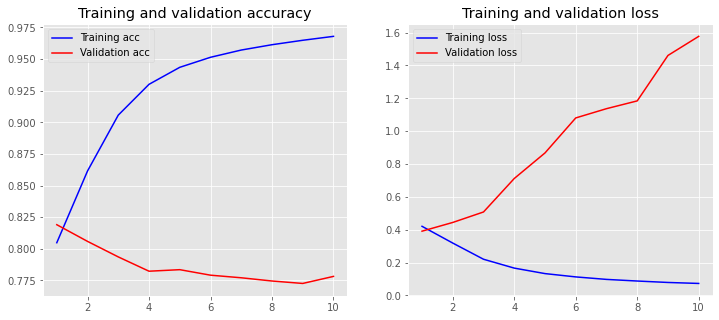

In [16]:
b2_history = b_model2.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = b_model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = b_model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(b2_history)

# With Maxpool

In [17]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

m_model = Sequential()
m_model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
m_model.add(layers.GlobalMaxPool1D())
m_model.add(layers.Dense(64, activation='relu'))
m_model.add(layers.Dense(64, activation='relu'))
m_model.add(layers.Dense(1, activation='sigmoid'))
m_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
m_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1234250   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,241,739
Trainable params: 1,241,739
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9509
Testing Accuracy:  0.7933


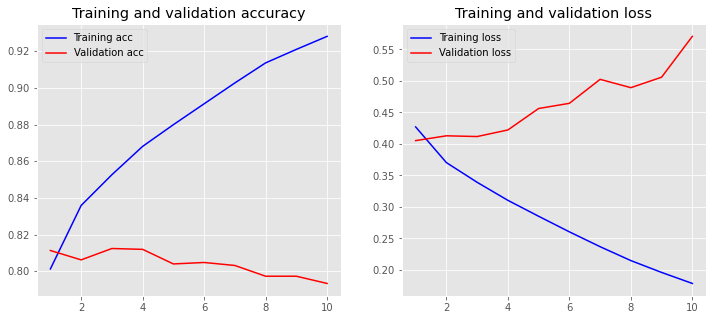

In [18]:
m_history = m_model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = m_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = m_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(m_history)

# CNN - Hyperparameter tuned

Ran Hyperparameter Tuning with gridsearch CV to find the best parameters: <br>
Filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)<br>
Kernel_size: specifying the length of the 1D convolution window.<br>

Observation:<br>
Model still overfitting but Test Accuracy slightly improved.<br>
As training & Test accuracy have a large variance, it means that the  model is overfitting.<br>
To try and overcome this problem we can use Regularization and Dropout rate while training.


In [19]:
def compare_loss_with_baseline(model, model_name):
    loss_base_model = b2_history.history['val_loss']
    loss_model = model.history['val_loss']

    e = range(1, 10 + 1)

    plt.plot(e, loss_base_model, 'b', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'bo', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()
    

In [20]:
embedding_dim = 50

h_model = Sequential()
h_model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
h_model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
h_model.add(layers.GlobalMaxPooling1D())
h_model.add(layers.Dense(64, activation='relu'))
h_model.add(layers.Dense(64, activation='relu'))
h_model.add(layers.Dense(1, activation='sigmoid'))
h_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
h_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           1234250   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 32)            8032      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,248,619
Trainable params: 1,248,619
Non-trainable params: 0
____________________________________________

Training Accuracy: 0.9747
Testing Accuracy:  0.7809


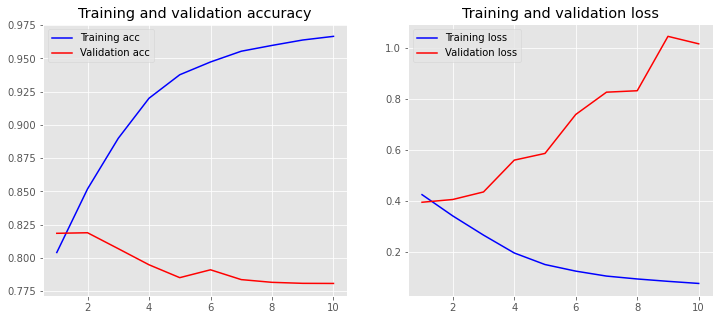

In [21]:
h_history = h_model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = h_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = h_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(h_history)

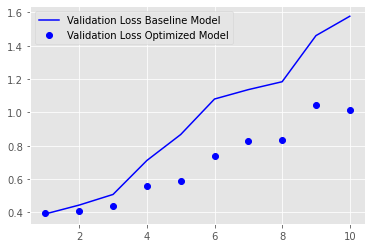

In [22]:
compare_loss_with_baseline(h_history, 'Optimized Model')

# Regularized Model

Adding a penalty through a regularizer of 0.001, which relays the weights in each layer to the final loss function. <br>

Observations:<br>
+0.0027 improvement on Test accuracy from CNN model
Model is still overfitting

In [23]:
reg_model = Sequential()
reg_model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
reg_model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
reg_model.add(layers.GlobalMaxPooling1D())
reg_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(1, activation='sigmoid'))
reg_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           1234250   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            8032      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 1,248,619
Trainable params: 1,248,619
Non-trainable params: 0
____________________________________________

Training Accuracy: 0.9767
Testing Accuracy:  0.7836


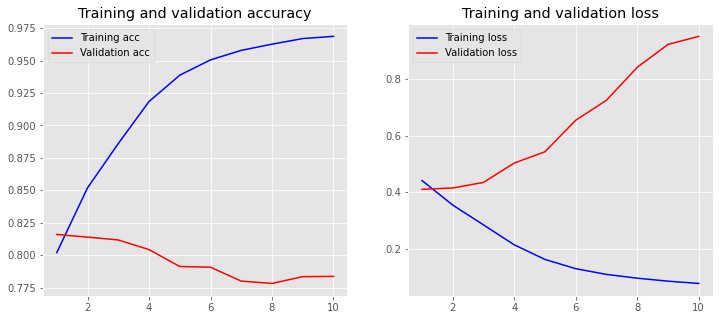

In [24]:
reg_history = reg_model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = reg_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = reg_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(reg_history)

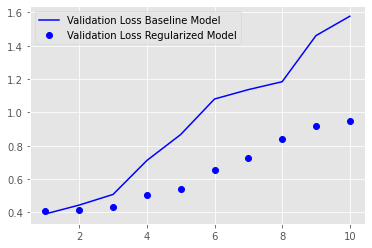

In [25]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

# Dropout Model

Dropout rate is a regularization technique in neural networks used to avoid overfitting training model, added 50% dropout rate to the model. <br>

Observations:<br>
+0.0061 improvement on Test accuracy from CNN model(Regularized)
Model is still overfitting

In [26]:
drop_model = Sequential()
drop_model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
drop_model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
drop_model.add(layers.GlobalMaxPooling1D())
drop_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(1, activation='sigmoid'))
drop_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
drop_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           1234250   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 32)            8032      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

Training Accuracy: 0.9710
Testing Accuracy:  0.7897


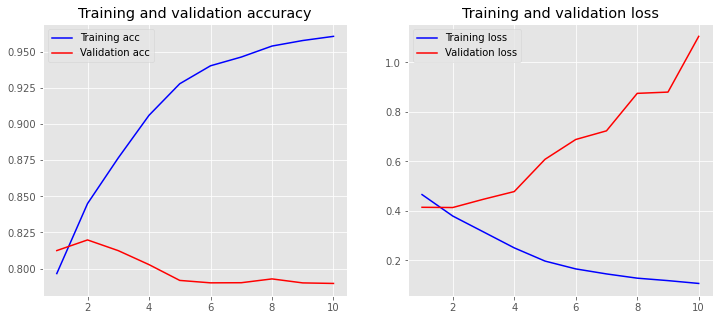

In [27]:
drop_history = drop_model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = drop_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = drop_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(drop_history)

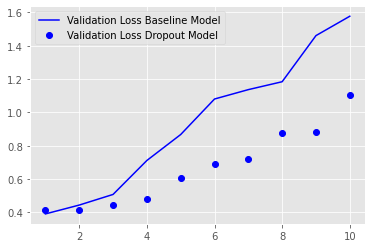

In [28]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

# Evaluate Models

## Train

****************
* Base-trained *
****************


/Users/wongkarmun/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy : 0.9738 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9693 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9786 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9738                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


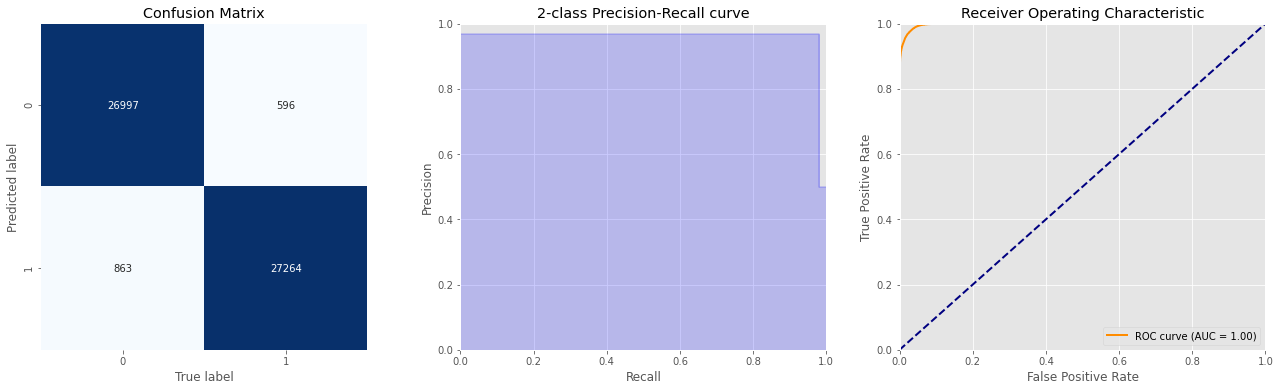


***************
* CNN-trained *
***************


/Users/wongkarmun/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy : 0.9747 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9710 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9787 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9747                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


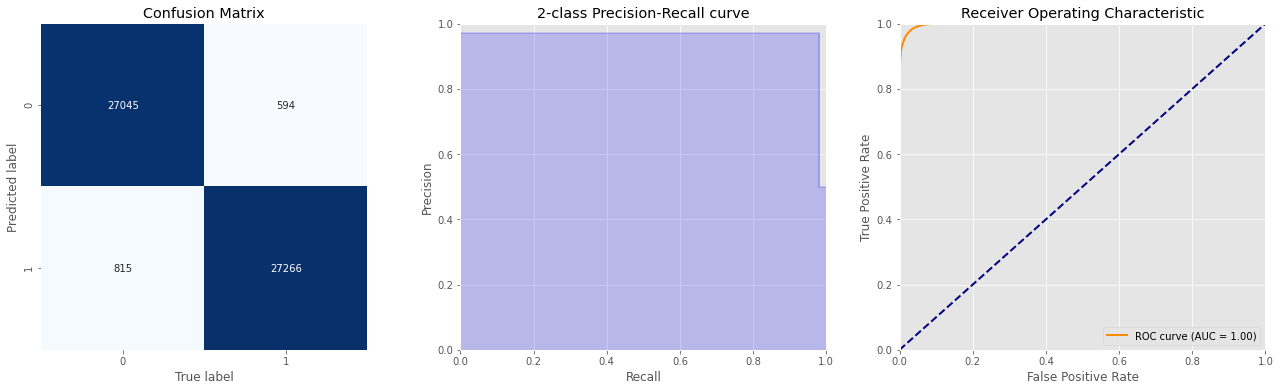


***********************
* Regularized-trained *
***********************


/Users/wongkarmun/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy : 0.9767 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9746 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9788 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9767                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


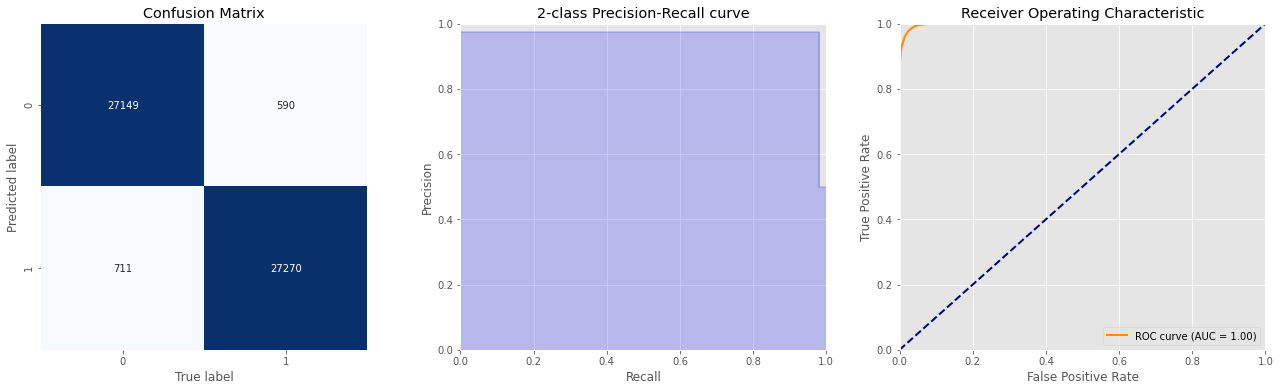


*******************
* Dropout-trained *
*******************


/Users/wongkarmun/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy : 0.9710 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9697 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9724 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9710                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


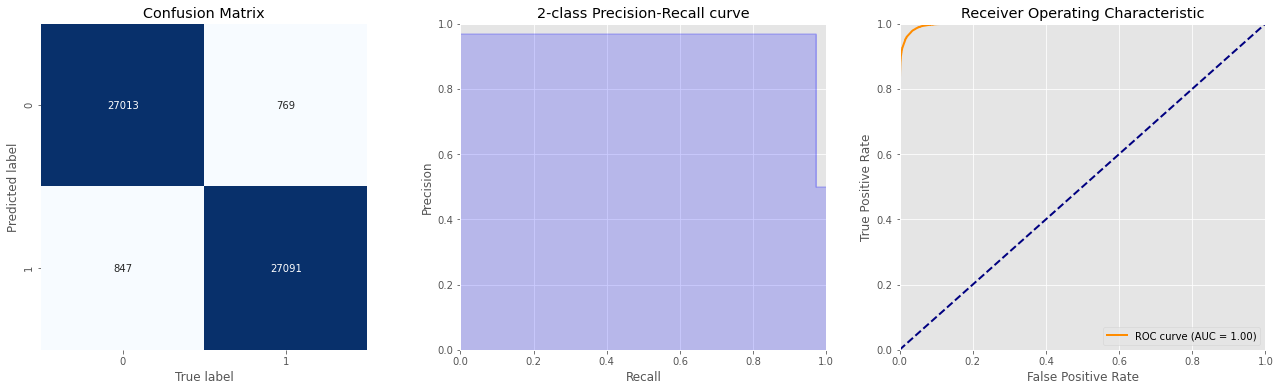

In [29]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Base-trained', 'CNN-trained', 'Regularized-trained','Dropout-trained']
for i, m in enumerate([b_model2, h_model,reg_model,drop_model]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    pred = m.predict(X_train)
    predictions = pred.round()
    probabilities = m.predict_proba(X_train)
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_train, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()

## Test

*************
* Base-test *
*************


/Users/wongkarmun/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy : 0.7782 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7828 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7701 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7782                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


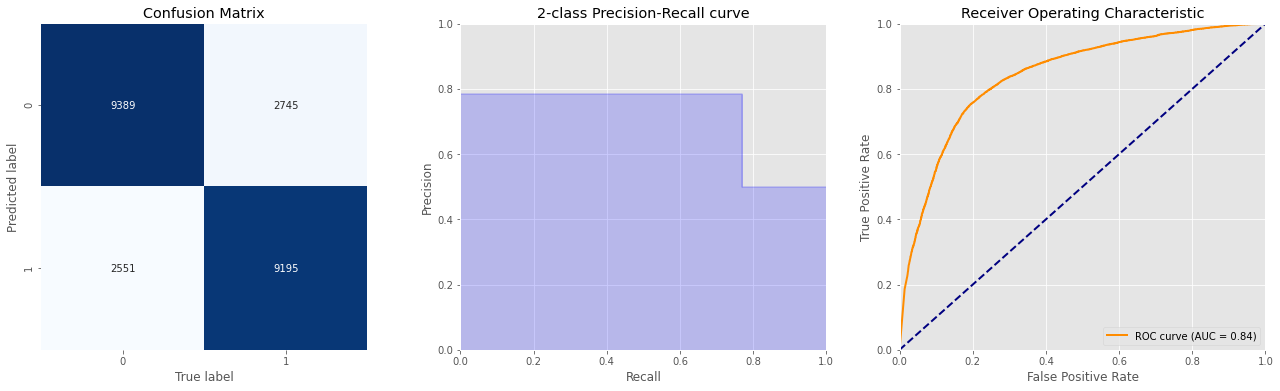


************
* CNN-test *
************


/Users/wongkarmun/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy : 0.7809 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7834 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7765 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7809                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


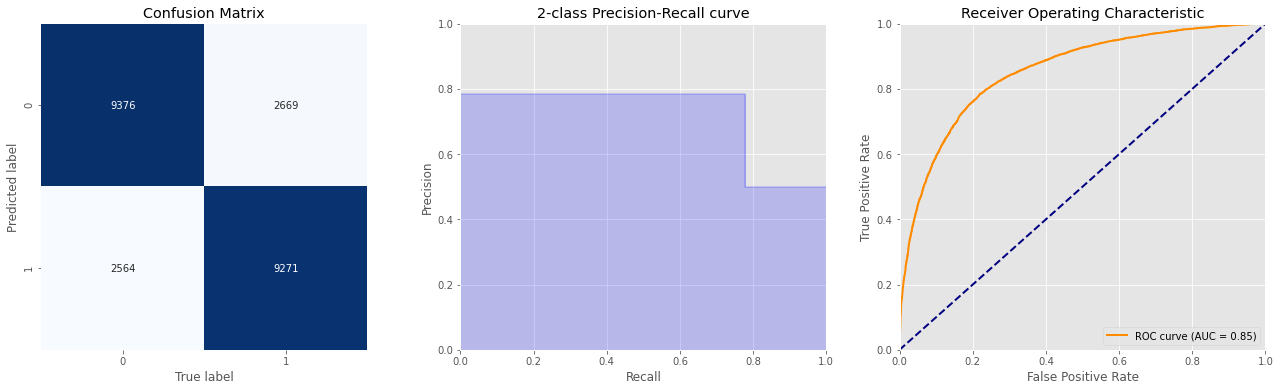


********************
* Regularized-test *
********************


/Users/wongkarmun/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy : 0.7836 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7954 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7637 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7836                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


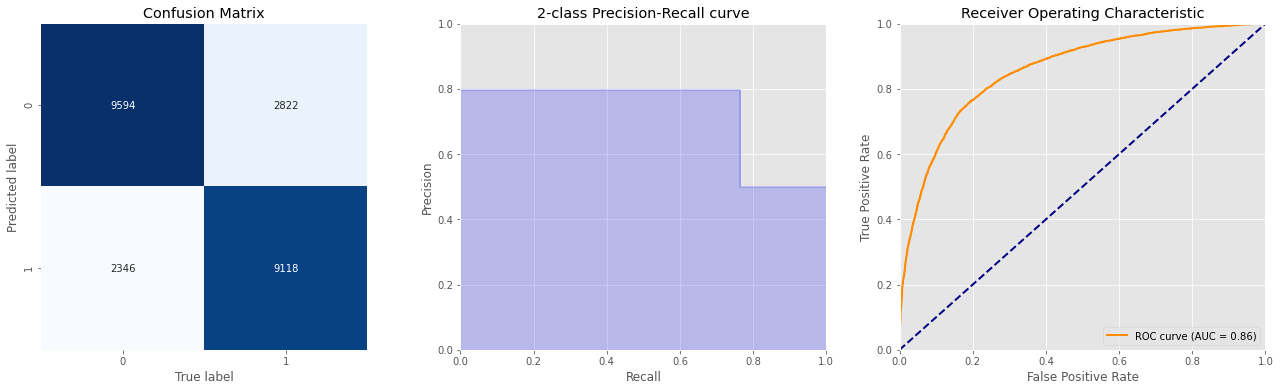


****************
* Dropout-test *
****************


/Users/wongkarmun/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy : 0.7897 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8168 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7470 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7897                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


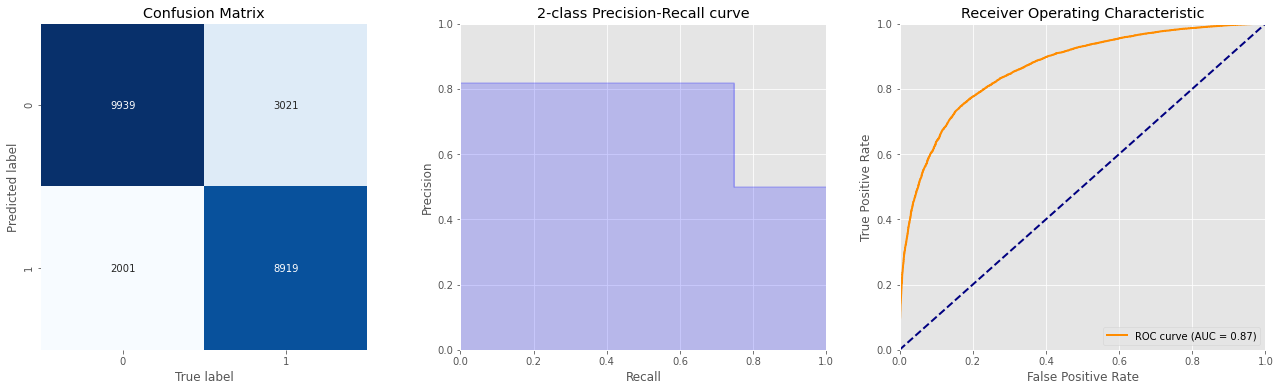

In [30]:
models = ['Base-test', 'CNN-test', 'Regularized-test','Dropout-test']
for i, m in enumerate([b_model2, h_model,reg_model,drop_model]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    pred = m.predict(X_test)
    predictions = pred.round()
    probabilities = m.predict_proba(X_test)
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()

# Clear session

In [31]:
# from keras.backend import clear_session
# clear_session()